In [1]:
# This implementation of the paper was done by Mr. Ravi Theja Kolluru in collaboration with Womanium and Classiq
#  Development of Novel Quantum Algorithms
#  Team Name: Raman Quantum 
#  Team Members: Ravi Theja Kolluru
#  Team Size: 1

# Paper Selected: Evidence for the utility of quantum computing before fault tolerance
# Paper Credits: Youngseok Kim1, Andrew Eddins2, Sajant Anand3, Ken Xuan Wei1, Ewout van den Berg1, Sami Rosenblatt1, Hasan Nayfeh1, Yantao Wu3,4, Michael Zaletel3,5, Kristan Temme1 & Abhinav Kandala1
# Reference link: https://www.nature.com/articles/s41586-023-06096-3

In [2]:
# Index
# The current document contains the following contents

# Notes
# Import Statements 
# Quantum Computer with errors for simulation
# Simple Quantum circuit
# Complex Quantum circuit
# Implementation for ZNE SIMPLE
# Circuit Execution Simple
# Implementation for ZNE Complex
# Circuit Execution Complex


In [3]:
# Notes

# Quantum Computer/Simulator: QASM simulator
# Error Identification & Simulations: Sparse Pauli Lindbland Noise Model
# Sample Circuit - Simple: CNOT gate
# Complex Circuit: Hamiltoniam mentioned in paper; Quantum Computer Node Architecture mentioned below
# Hamiltonian mentioned the paper: H = −∑JZZ + ∑hX
# Hamiltonian is converted into trotterized evolution in the form of RZZ, RX
# Computer Architcture Dependent. 
# Error Correction Algorithm: ZNE
# ZNE type: local folding





In [4]:
# Import statements
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.providers.aer.noise import NoiseModel, pauli_error, QuantumError
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import coherent_unitary_error
from qiskit.circuit.library import RXGate, RZZGate
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import networkx as nx


In [5]:
# Quantum Computer with errors for simulation
def quantumComputer(quantumCkt, errorFraction):
    # Define the noise model
    noise_model = NoiseModel()
    errorRate = errorFraction/20
    identityRate = 1-errorRate

    # Define the sparse Pauli-Lindblad errors
    
    # Simple - x, z, cx errors
    # Bit-flip error on a single qubit with probability 0.1
    bit_flip_error = pauli_error([('X', errorRate), ('I', identityRate)])
    # Phase-flip error on a single qubit with probability 0.1
    phase_flip_error = pauli_error([('Z', errorRate), ('I', identityRate)])
    # Define a two-qubit depolarizing error for the CX gate with a small probability
    cx_error = depolarizing_error(2*errorRate/10, 2)
    
    # Complex - Rx & Rzz errors
    # Define Rx error with a small rotation angle
    theta_rx = errorRate
    rx_error = coherent_unitary_error(RXGate(theta_rx).to_matrix())
    # Define RZZ error with a small rotation angle
    theta_rzz = errorRate
    rzz_error = coherent_unitary_error(RZZGate(theta_rzz).to_matrix())

    # Add errors to the noise model
    
    # Simple
    noise_model.add_all_qubit_quantum_error(bit_flip_error, ['h'])
    noise_model.add_all_qubit_quantum_error(phase_flip_error, ['z'])
    noise_model.add_quantum_error(cx_error, 'cx', [0, 1])
    
    # Complex 
    # Add Rx error to the noise model for RX gates
    noise_model.add_all_qubit_quantum_error(rx_error, ['rx'])
    # Add RZZ error to the noise model for RZZ gates
    noise_model.add_all_qubit_quantum_error(rzz_error, ['rzz'])
    
    return noise_model
    

In [6]:
# Simple Quantum circuit
def simpleQuantumCircuit(quantumCktSimple, repeat):
#     local folding, repeating 2n+1 number of times
    
    for i in range(repeat):
        quantumCktSimple.x(0)
    for i in range(repeat):
        quantumCktSimple.cx(0, 1)
    return quantumCktSimple
    
    

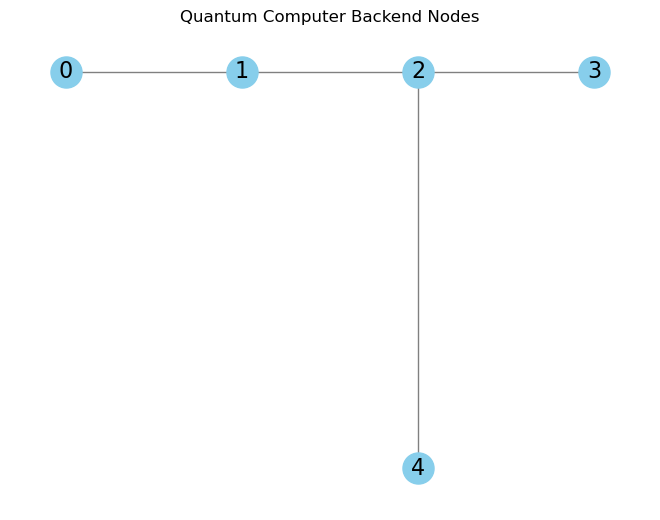

In [7]:
# Sample Backend for the complex circuits 

# Create a graph object
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from([0, 1, 2, 3, 4])

# Add horizontal edges
G.add_edges_from([(0, 1), (1, 2), (2, 3)])

# Add vertical edge
G.add_edge(2, 4)

# Define positions for the nodes
pos = {
    0: (0, 0),  # First horizontal node
    1: (1, 0),  # Second horizontal node
    2: (2, 0),  # Third horizontal node (connected to vertical node)
    3: (3, 0),  # Fourth horizontal node
    4: (2, -1)  # Vertical node below the third horizontal node
}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=16)

# Show the plot
plt.title("Quantum Computer Backend Nodes")
plt.show()


In [8]:

# Complex Quantum circuit

def complexQuantumCircuit(quantumCktComplex,repeat):
#     The plan is to apply a X gate to Node 2 and apply a CNOT gate on nodes 2(control),4. 
#     local folding, repeating 2n+1 number of times
# #     As only 2 qubits are required in this circuit, considering the qubits ot be 0 (control) and 1 
# #     J alias J24 has the value 1 as they are connected as per the condition given in the paper
#     pi=3.14
#     J = 1
#     theta_J = 2*J*pi/4
#     h = 1
#     theta_h = 2*h*pi/4
    
    for i in range(repeat):
        # Apply Hadamard gate to the target qubit (qubit 1)
        quantumCktComplex.h(0)
        quantumCktComplex.h(1)
    for i in range(repeat):
        quantumCktComplex.append(RZZGate(np.pi), [0, 1])
    for i in range(repeat):
        # Apply Hadamard gate to the target qubit (qubit 1)
        quantumCktComplex.h(0)
        quantumCktComplex.h(1)
        
    return quantumCktComplex
    
    
    


In [9]:
# Implementation for ZNE SIMPLE
def ZNEImplementationSimple(quantumCktSimple):
    
    n = 10
    trotterSteps = np.empty(n)
    zneProb = np.empty(n, dtype=float)
    zneProbs = []
    weights = np.empty(n)
    count = 0
    for i in range(n,0,-1):
        weights[count] =i
        count+=1
        
    
#   Generating rate of accuracy for various error scenario expected values - data preperation
    for i in range(n): 
        quantumCktSimple=QuantumCircuit(2)
        repeat = 2*i+1
        quantumCktSimple = simpleQuantumCircuit(quantumCktSimple,repeat)
          
        quantumCktSimple.measure_all()
        # Calling Quantum Computer with error
        noise_model = quantumComputer(quantumCktSimple,i)
        # simulator circuit
        backend = Aer.get_backend('qasm_simulator')
        # Execute the circuit with noise
        result = execute(quantumCktSimple, backend, noise_model=noise_model, shots=1000).result()
        counts = result.get_counts()
        zneProb = counts.get('11')
        
        trotterSteps[i] = repeat
        trotterSteps = np.array(trotterSteps).reshape(-1,1)
        zneProbs.append(zneProb/1000)



    
    # Add a constant (intercept term) to the independent variable
    X = sm.add_constant(trotterSteps)
    y = zneProbs
    
    print("X",X)
    print("y",y)

    # Fit the weighted least squares regression model
    model = sm.WLS(y, X, weights=weights)
    results = model.fit()

    # Predict values
    y_pred = results.predict(X)
    zeroErrorValue = results.predict(sm.add_constant(np.array([0])))
    
    
    print(results.predict(sm.add_constant(np.array([0]))))

    # Plot the data points
    plt.scatter(X[:, 1], y, s=50, alpha=0.5, label='Data Points')
    # Plot the regression line
    plt.plot(X[:, 1], y_pred, color='red', linestyle='--',label='Fitted Line')
    plt.axvline(x=1, color='green',  label='Vertical Line at x=1')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('ZNE')
    plt.legend()
    plt.show()



        
    return zeroErrorValue
    

X [[ 1.  1.]
 [ 1.  3.]
 [ 1.  5.]
 [ 1.  7.]
 [ 1.  9.]
 [ 1. 11.]
 [ 1. 13.]
 [ 1. 15.]
 [ 1. 17.]
 [ 1. 19.]]
y [1.0, 0.994, 0.992, 0.977, 0.981, 0.97, 0.957, 0.946, 0.956, 0.942]
[1.0046697]


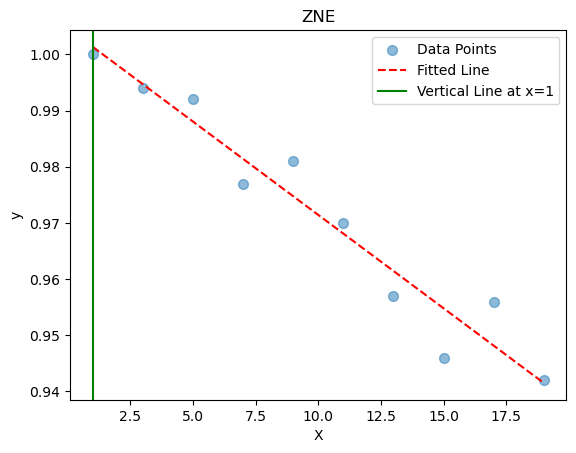

Zero Error Simple :  [1.0046697]


In [10]:

# Circuit Execution Simple
quantumCktSimple=QuantumCircuit(2)
zeroErrorSimple = ZNEImplementationSimple(quantumCktSimple)
print("Zero Error Simple : ",zeroErrorSimple)

In [11]:
# Implementation for ZNE Complex
def ZNEImplementationComplex(quantumCktComplex):
    
    n = 10
    trotterStepsComplex = np.empty(n)
    zneProbComplex = np.empty(n, dtype=float)
    zneProbsComplex = []
    weights = np.empty(n)
    count = 0
    for i in range(n,0,-1):
        weights[count] =i
        count+=1
        
    
#   Generating rate of accuracy for various error scenario expected values - data preperation
    for i in range(n): 
        quantumCktComplex=QuantumCircuit(2)
        repeat = 2*i+1
        quantumCktComplex = complexQuantumCircuit(quantumCktComplex,repeat)
          
        quantumCktComplex.measure_all()
        # Calling Quantum Computer with error
        noise_model_Complex = quantumComputer(quantumCktComplex,i)
        # simulator circuit
        backend = Aer.get_backend('qasm_simulator')
        # Execute the circuit with noise
        resultComplex = execute(quantumCktComplex, backend, noise_model=noise_model_Complex, shots=1000).result()
        countsComplex = resultComplex.get_counts()
        zneProbComplex = countsComplex.get('11')
        
        trotterStepsComplex[i] = repeat
        trotterStepsComplex = np.array(trotterStepsComplex).reshape(-1,1)
        zneProbsComplex.append(zneProbComplex/1000)



    
    # Add a constant (intercept term) to the independent variable
    X_complex = sm.add_constant(trotterStepsComplex)
    y_complex = zneProbsComplex

    # Fit the weighted least squares regression model
    modelComplex = sm.WLS(y_complex, X_complex, weights=weights)
    resultsComplex = modelComplex.fit()

    # Predict values
    y_pred_complex = resultsComplex.predict(X_complex)
    zeroErrorValueComplex = resultsComplex.predict(sm.add_constant(np.array([0])))
    
    
    print(resultsComplex.predict(sm.add_constant(np.array([0]))))

    # Plot the data points
    plt.scatter(X_complex[:, 1], y_pred_complex, s=50, alpha=0.5, label='Data Points')
    # Plot the regression line
    plt.plot(X_complex[:, 1], y_pred_complex, color='red', linestyle='--',label='Fitted Line')
    plt.axvline(x=1, color='green',  label='Vertical Line at x=1')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('ZNE')
    plt.legend()
    plt.show()



        
    return zeroErrorValueComplex
    

[1.04918485]


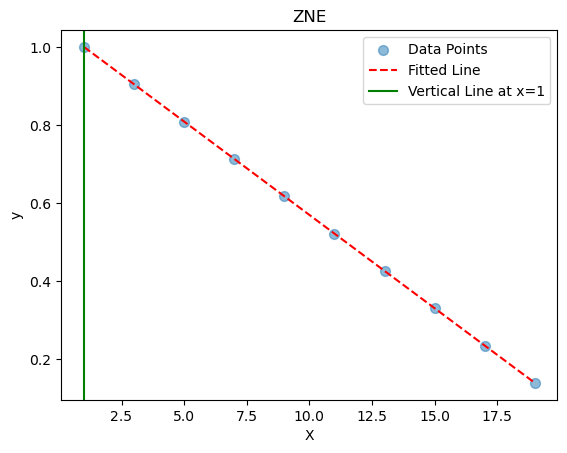

Zero Error Simple :  [1.04918485]


In [12]:

# Circuit Execution Complex
quantumCktComplex=QuantumCircuit(2)
zeroErrorComplex = ZNEImplementationComplex(quantumCktComplex)
print("Zero Error Complex : ",zeroErrorComplex)

In [16]:
# Post Processing 
print("The expected value is 1.000; The extrapolated zero error value for simple CNOT case is ",zeroErrorSimple," ; & The extrapolated zero error value for extrapolated value is ", zeroErrorComplex)
accuracySimple = abs(zeroErrorSimple-1.000)*100
accuracySimplePercentage = 100-accuracySimple
accuracyComplex = abs(zeroErrorComplex-1.000)*100
accuracyComplexPercentage = 100-accuracyComplex

print("Simple Equation Accuracy : ",accuracySimplePercentage)

print("Complex Equation Accuracy : ",accuracyComplexPercentage)



The expected value is 1.000; The extrapolated zero error value for simple CNOT case is  [1.0046697]  ; & The extrapolated zero error value for extrapolated value is  [1.04918485]
Simple Equation Accuracy :  [99.5330303]
Complex Equation Accuracy :  [95.08151515]
